#TransformerによるByからのJzの推定
https://qiita.com/kodakoda-koda/items/7c046f1c0da60e8a4ff8

https://github.com/kodakoda-koda/Transformer_TimeSeriesForecasting/blob/main/Transformer.ipynb



## Library

In [1]:
# !pip install pandas
# !pip install matplotlib
# !pip install scikit-learn

In [1]:
# ライブラリのインポート
import math
import numpy as np
import pandas as pd

# import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.nn import LayerNorm
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerEncoder, TransformerDecoder, TransformerEncoderLayer, TransformerDecoderLayer

# ランダムシードの設定
fix_seed = 2023
np.random.seed(fix_seed)
torch.manual_seed(fix_seed)

# デバイスの設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# dataディレクトリの生成
import os

if not os.path.exists("../data/"):
    os.makedirs("../data/")

input_data_dir = "../data/"

# Outputディレクトリの生成

if not os.path.exists("./out/"):
    os.makedirs("./out/")

out_dir = "./out/"

# csvディレクトリの生成
import os

if not os.path.exists("./csv_data/"):
    os.makedirs("./csv_data/")

csv_data_dir = "./csv_data/"

# pngディレクトリの生成

if not os.path.exists("./png_data/"):
    os.makedirs("./png_data/")

png_data_dir = "./png_data/"

In [20]:
import pandas as pd
import numpy as np

# ファイルのインポート
# ファイルパスは適宜変更してください

bLine1 = pd.read_table(input_data_dir + "bLineRx_m1f10_updownpause_y001.txt", header=None, names=["Step", "Time", "xb", "yb", "zb", "Bx", "By", "Bz"], keep_default_na=False, engine="python", sep="\ +")  # "\ +" は正規表現で空白1文字が続くもので区切れる。
bLine2 = pd.read_table(input_data_dir + "bLineRx_m1f10_updownpause_y0005.txt", header=None, names=["Step", "Time", "xb", "yb", "zb", "Bx", "By", "Bz"], keep_default_na=False, engine="python", sep="\ +")
bLine3 = pd.read_table(input_data_dir + "bLineRx_m1f10_updownpause_y0007.txt", header=None, names=["Step", "Time", "xb", "yb", "zb", "Bx", "By", "Bz"], keep_default_na=False, engine="python", sep="\ +")

bLine4 = pd.read_table(input_data_dir + "bLineRx_m1f10_triangle_y001.txt", header=None, names=["Step", "Time", "xb", "yb", "zb", "Bx", "By", "Bz"], keep_default_na=False, engine="python", sep="\ +")
bLine5 = pd.read_table(input_data_dir + "bLineRx_m1f10_triangle_y0005.txt", header=None, names=["Step", "Time", "xb", "yb", "zb", "Bx", "By", "Bz"], keep_default_na=False, engine="python", sep="\ +")
bLine6 = pd.read_table(input_data_dir + "bLineRx_m1f10_triangle_y0007.txt", header=None, names=["Step", "Time", "xb", "yb", "zb", "Bx", "By", "Bz"], keep_default_na=False, engine="python", sep="\ +")

bLine7 = pd.read_table(input_data_dir + "bLineRx_m1f10_uppausedown_y001.txt", header=None, names=["Step", "Time", "xb", "yb", "zb", "Bx", "By", "Bz"], keep_default_na=False, engine="python", sep="\ +")
bLine8 = pd.read_table(input_data_dir + "bLineRx_m1f10_uppausedown_y0005.txt", header=None, names=["Step", "Time", "xb", "yb", "zb", "Bx", "By", "Bz"], keep_default_na=False, engine="python", sep="\ +")
bLine9 = pd.read_table(input_data_dir + "bLineRx_m1f10_uppausedown_y0007.txt", header=None, names=["Step", "Time", "xb", "yb", "zb", "Bx", "By", "Bz"], keep_default_na=False, engine="python", sep="\ +")

bLine10 = pd.read_table(input_data_dir + "bLineRx_m1f10_sin_y001.txt", header=None, names=["Step", "Time", "xb", "yb", "zb", "Bx", "By", "Bz"], keep_default_na=False, engine="python", sep="\ +")
bLine11 = pd.read_table(input_data_dir + "bLineRx_m1f10_sin_y0005.txt", header=None, names=["Step", "Time", "xb", "yb", "zb", "Bx", "By", "Bz"], keep_default_na=False, engine="python", sep="\ +")
bLine12 = pd.read_table(input_data_dir + "bLineRx_m1f10_sin_y0007.txt", header=None, names=["Step", "Time", "xb", "yb", "zb", "Bx", "By", "Bz"], keep_default_na=False, engine="python", sep="\ +")

"""
何故か
jLineRx_m1f10_updownpause_y0.txt,
jLineRx_m1f10_triangle_y0.txt,
jLineRx_m1f10_uppausedown_y0.txt,
jLineRx_m1f10_sin_y0.txt
のときに電流密度の取りうる300点の座標が異なり、concatできないため、
上記4つのファイルは除外する。
"""

# jLine13 = pd.read_table(input_data_dir + "jLineRx_m1f10_updownpause_y0.txt", header=None, names=["Step", "Time", "xj", "yj", "zj", "Jx", "Jy", "Jz"], keep_default_na=False, engine="python", sep="\ +")
jLine1 = pd.read_table(input_data_dir + "jLineRx_m1f10_updownpause_y001.txt", header=None, names=["Step", "Time", "xj", "yj", "zj", "Jx", "Jy", "Jz"], keep_default_na=False, engine="python", sep="\ +")
jLine2 = pd.read_table(input_data_dir + "jLineRx_m1f10_updownpause_y004.txt", header=None, names=["Step", "Time", "xj", "yj", "zj", "Jx", "Jy", "Jz"], keep_default_na=False, engine="python", sep="\ +")
jLine3 = pd.read_table(input_data_dir + "jLineRx_m1f10_updownpause_y0025.txt", header=None, names=["Step", "Time", "xj", "yj", "zj", "Jx", "Jy", "Jz"], keep_default_na=False, engine="python", sep="\ +")

# jLine14 = pd.read_table(input_data_dir + "jLineRx_m1f10_triangle_y0.txt", header=None, names=["Step", "Time", "xj", "yj", "zj", "Jx", "Jy", "Jz"], keep_default_na=False, engine="python", sep="\ +")
jLine4 = pd.read_table(input_data_dir + "jLineRx_m1f10_triangle_y001.txt", header=None, names=["Step", "Time", "xj", "yj", "zj", "Jx", "Jy", "Jz"], keep_default_na=False, engine="python", sep="\ +")
jLine5 = pd.read_table(input_data_dir + "jLineRx_m1f10_triangle_y004.txt", header=None, names=["Step", "Time", "xj", "yj", "zj", "Jx", "Jy", "Jz"], keep_default_na=False, engine="python", sep="\ +")
jLine6 = pd.read_table(input_data_dir + "jLineRx_m1f10_triangle_y0025.txt", header=None, names=["Step", "Time", "xj", "yj", "zj", "Jx", "Jy", "Jz"], keep_default_na=False, engine="python", sep="\ +")

# jLine15 = pd.read_table(input_data_dir + "jLineRx_m1f10_uppausedown_y0.txt", header=None, names=["Step", "Time", "xj", "yj", "zj", "Jx", "Jy", "Jz"], keep_default_na=False, engine="python", sep="\ +")
jLine7 = pd.read_table(input_data_dir + "jLineRx_m1f10_uppausedown_y001.txt", header=None, names=["Step", "Time", "xj", "yj", "zj", "Jx", "Jy", "Jz"], keep_default_na=False, engine="python", sep="\ +")
jLine8 = pd.read_table(input_data_dir + "jLineRx_m1f10_uppausedown_y004.txt", header=None, names=["Step", "Time", "xj", "yj", "zj", "Jx", "Jy", "Jz"], keep_default_na=False, engine="python", sep="\ +")
jLine9 = pd.read_table(input_data_dir + "jLineRx_m1f10_uppausedown_y0025.txt", header=None, names=["Step", "Time", "xj", "yj", "zj", "Jx", "Jy", "Jz"], keep_default_na=False, engine="python", sep="\ +")

# jLine16 = pd.read_table(input_data_dir + "jLineRx_m1f10_sin_y0.txt", header=None, names=["Step", "Time", "xj", "yj", "zj", "Jx", "Jy", "Jz"], keep_default_na=False, engine="python", sep="\ +")
jLine10 = pd.read_table(input_data_dir + "jLineRx_m1f10_sin_y001.txt", header=None, names=["Step", "Time", "xj", "yj", "zj", "Jx", "Jy", "Jz"], keep_default_na=False, engine="python", sep="\ +")
jLine11 = pd.read_table(input_data_dir + "jLineRx_m1f10_sin_y004.txt", header=None, names=["Step", "Time", "xj", "yj", "zj", "Jx", "Jy", "Jz"], keep_default_na=False, engine="python", sep="\ +")
jLine12 = pd.read_table(input_data_dir + "jLineRx_m1f10_sin_y0025.txt", header=None, names=["Step", "Time", "xj", "yj", "zj", "Jx", "Jy", "Jz"], keep_default_na=False, engine="python", sep="\ +")


for i in range(1, 13):
    eval(f"bLine{i}").to_csv(csv_data_dir + f"bLine{i}.csv")

for i in range(1, 17):
    eval(f"jLine{i}").to_csv(csv_data_dir + f"jLine{i}.csv")


In [43]:
bLine1

,Step,Time,xb,yb,zb,Bx,By,Bz
0,0,0.0,0.00001,0.01,0,0.000000,0.000000,0
1,1,0.1,0.00001,0.01,0,-0.000134,0.008838,0
2,2,0.2,0.00001,0.01,0,-0.000268,0.017775,0
3,3,0.3,0.00001,0.01,0,-0.000403,0.026825,0
4,4,0.4,0.00001,0.01,0,-0.000539,0.035992,0
...,...,...,...,...,...,...,...,...
45446,146,14.6,0.01249,0.01,0,0.054608,0.031240,0
45447,147,14.7,0.01249,0.01,0,0.054573,0.031218,0
45448,148,14.8,0.01249,0.01,0,0.054539,0.031196,0
45449,149,14.9,0.01249,0.01,0,0.054505,0.031175,0


In [46]:
for i in range(1, 13):
    globals()[f"df_bLine{i}"] = globals()[f"bLine{i}"].drop(["Time", "yb", "zb", "Bz", "By"], axis=1)

for i in range(1, 13):
    globals()[f"df_jLine{i}"] = globals()[f"jLine{i}"].drop(["Time", "yj", "zj", "Jx", "Jy"], axis=1)

In [48]:
df_bLine1

,Step,xb,Bx
0,0,0.00001,0.000000
1,1,0.00001,-0.000134
2,2,0.00001,-0.000268
3,3,0.00001,-0.000403
4,4,0.00001,-0.000539
...,...,...,...
45446,146,0.01249,0.054608
45447,147,0.01249,0.054573
45448,148,0.01249,0.054539
45449,149,0.01249,0.054505


In [49]:
# stepをもとにマルチカラムに変換
for i in range(1, 13):
    globals()[f"df_multi_bLine{i}"] = globals()[f"df_bLine{i}"].pivot_table(index="Step", columns="xb")

for i in range(1, 13):
    globals()[f"df_multi_jLine{i}"] = globals()[f"df_jLine{i}"].pivot_table(index="Step", columns="xj")

In [50]:
df_multi_bLine1

Bx                                                              \
xb    0.000010  0.000052  0.000093  0.000135  0.000176  0.000218  0.000260   
Step                                                                         
0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1    -0.000134 -0.000134 -0.000134 -0.000134 -0.000134 -0.000134 -0.000134   
2    -0.000268 -0.000268 -0.000268 -0.000268 -0.000268 -0.000268 -0.000268   
3    -0.000403 -0.000403 -0.000403 -0.000403 -0.000403 -0.000403 -0.000403   
4    -0.000539 -0.000539 -0.000539 -0.000539 -0.000539 -0.000539 -0.000539   
...        ...       ...       ...       ...       ...       ...       ...   
146   0.000260  0.000260  0.000260  0.000260  0.000260  0.000260  0.000260   
147   0.000260  0.000260  0.000260  0.000260  0.000260  0.000260  0.000260   
148   0.000260  0.000260  0.000260  0.000260  0.000260  0.000260  0.000260   
149   0.000260  0.000260  0.000260  0.000260  0.000260  0.000260  0.000260   
150   0.000260  0.000260  0.000260  0.000260  0.000260  0.000260  0.000260   

                                    ...                                \
xb    0.000301  0.000343  0.000384  ...  0.012116  0.012157  0.012199   
Step                                ...                                 
0     0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
1    -0.000338 -0.000338 -0.000338  ... -0.006648 -0.006648 -0.006648   
2    -0.000679 -0.000679 -0.000679  ... -0.013131 -0.013131 -0.013131   
3    -0.001021 -0.001021 -0.001021  ... -0.019440 -0.019440 -0.019440   
4    -0.001364 -0.001364 -0.001364  ... -0.025589 -0.025589 -0.025589   
...        ...       ...       ...  ...       ...       ...       ...   
146   0.000668  0.000668  0.000668  ...  0.055389  0.055389  0.055389   
147   0.000668  0.000668  0.000668  ...  0.055354  0.055354  0.055354   
148   0.000667  0.000667  0.000667  ...  0.055320  0.055320  0.055320   
149   0.000667  0.000667  0.000667  ...  0.055286  0.055286  0.055286   
150   0.000667  0.000667  0.000667  ...  0.055253  0.055253  0.055253   

                                                                            
xb    0.012240  0.012282  0.012324  0.012365  0.012407  0.012448  0.012490  
Step                                                                        
0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1    -0.006538 -0.006538 -0.006538 -0.006538 -0.006538 -0.006538 -0.006538  
2    -0.012904 -0.012904 -0.012904 -0.012904 -0.012904 -0.012904 -0.012904  
3    -0.019092 -0.019092 -0.019092 -0.019092 -0.019092 -0.019092 -0.019092  
4    -0.025115 -0.025115 -0.025115 -0.025115 -0.025115 -0.025115 -0.025115  
...        ...       ...       ...       ...       ...       ...       ...  
146   0.054608  0.054608  0.054608  0.054608  0.054608  0.054608  0.054608  
147   0.054573  0.054573  0.054573  0.054573  0.054573  0.054573  0.054573  
148   0.054539  0.054539  0.054539  0.054539  0.054539  0.054539  0.054539  
149   0.054505  0.054505  0.054505  0.054505  0.054505  0.054505  0.054505  
150   0.054473  0.054473  0.054473  0.054473  0.054473  0.054473  0.054473  

[151 rows x 301 columns]

In [51]:
for i in range(1, 13):
    globals()[f"df_single_bLine{i}"] = globals()[f"df_multi_bLine{i}"].reset_index(level=0).drop(["Step"], axis=1)

for i in range(1, 13):
    globals()[f"df_single_jLine{i}"] = globals()[f"df_multi_jLine{i}"].reset_index(level=0).drop(["Step"], axis=1)

/var/folders/fd/wnkbrjl93y7dx79_73lc0rd00000gp/T/ipykernel_10064/1697134877.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  globals()[f"df_single_bLine{i}"] = globals()[f"df_multi_bLine{i}"].reset_index(level=0).drop(["Step"], axis=1)
/var/folders/fd/wnkbrjl93y7dx79_73lc0rd00000gp/T/ipykernel_10064/1697134877.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  globals()[f"df_single_bLine{i}"] = globals()[f"df_multi_bLine{i}"].reset_index(level=0).drop(["Step"], axis=1)
/var/folders/fd/wnkbrjl93y7dx79_73lc0rd00000gp/T/ipykernel_10064/1697134877.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  globals()[f"df_single_bLine{i}"] = globals()[f"df_multi_bLine{i}"].reset_index(level=0).drop(["Step"], axis=1)
/var/folders/fd/wnkbrjl93y7dx79_73lc0rd00000gp/T/ipykernel_10064/1697134877.py:2: Per

In [52]:
df_single_jLine5

Jz                                                         \
xj         0.0   0.000042   0.000083   0.000125   0.000167   0.000208   
0     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
1     0.341349   0.341349   0.341349   0.341349   0.341349   0.341349   
2     0.691477   0.691477   0.691477   0.691477   0.691477   0.691477   
3     1.051935   1.051935   1.051935   1.051935   1.051935   1.051935   
4     1.423622   1.423622   1.423622   1.423622   1.423622   1.423622   
..         ...        ...        ...        ...        ...        ...   
146  44.637134  44.637134  44.637134  44.637134  44.637134  44.637134   
147  34.236468  34.236468  34.236468  34.236468  34.236468  34.236468   
148  18.379453  18.379453  18.379453  18.379453  18.379453  18.379453   
149  -0.608360  -0.608360  -0.608360  -0.608360  -0.608360  -0.608360   
150 -21.242375 -21.242375 -21.242375 -21.242375 -21.242375 -21.242375   

                                                       ...                \
xj      0.00025    0.000292     0.000333     0.000375  ...      0.012125   
0      0.000000    0.000000     0.000000     0.000000  ...  0.000000e+00   
1     -0.962853   -0.962853   -12.240958   -12.240958  ...  5.373500e+05   
2     -1.950424   -1.950424   -24.797957   -24.797957  ... -9.429562e+06   
3     -2.967059   -2.967059   -37.727607   -37.727607  ...  2.656510e+08   
4     -4.015230   -4.015230   -51.063721   -51.063721  ...  3.009614e+08   
..          ...         ...          ...          ...  ...           ...   
146 -294.230144 -294.230144  3121.699627  3121.699627  ...  3.425940e+08   
147 -244.195489 -244.195489  2890.747861  2890.747861  ...  3.427753e+08   
148 -159.474281 -159.474281  2313.810257  2313.810257  ...  3.429587e+08   
149  -55.855939  -55.855939  1567.035124  1567.035124  ...  3.431339e+08   
150   57.381783   57.381783   739.491766   739.491766  ...  3.433042e+08   

                                                                           \
xj       0.012167      0.012208       0.01225      0.012292      0.012333   
0    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1    5.373500e+05 -1.209870e+07  1.138190e+08  2.720525e+08  2.720525e+08   
2   -9.429562e+06  2.248485e+08  2.924294e+08  2.987102e+08  2.987102e+08   
3    2.656510e+08  2.972861e+08  3.084909e+08  3.103375e+08  3.103375e+08   
4    3.009614e+08  3.108776e+08  3.161841e+08  3.169673e+08  3.169673e+08   
..            ...           ...           ...           ...           ...   
146  3.425940e+08  3.430531e+08  3.434921e+08  3.436122e+08  3.436122e+08   
147  3.427753e+08  3.432249e+08  3.436569e+08  3.437770e+08  3.437770e+08   
148  3.429587e+08  3.433985e+08  3.438234e+08  3.439435e+08  3.439435e+08   
149  3.431339e+08  3.435646e+08  3.439828e+08  3.441028e+08  3.441028e+08   
150  3.433042e+08  3.437261e+08  3.441379e+08  3.442580e+08  3.442580e+08   

                                                             
xj       0.012375      0.012417      0.012458        0.0125  
0    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
1    2.720525e+08  2.720525e+08  2.720525e+08  2.720525e+08  
2    2.987102e+08  2.987102e+08  2.987102e+08  2.987102e+08  
3    3.103375e+08  3.103375e+08  3.103375e+08  3.103375e+08  
4    3.169673e+08  3.169673e+08  3.169673e+08  3.169673e+08  
..            ...           ...           ...           ...  
146  3.436122e+08  3.436122e+08  3.436122e+08  3.436122e+08  
147  3.437770e+08  3.437770e+08  3.437770e+08  3.437770e+08  
148  3.439435e+08  3.439435e+08  3.439435e+08  3.439435e+08  
149  3.441028e+08  3.441028e+08  3.441028e+08  3.441028e+08  
150  3.442580e+08  3.442580e+08  3.442580e+08  3.442580e+08  

[151 rows x 301 columns]

In [59]:
# すべてのデータのtmpを作る
for i in range(1, 13):
    globals()[f"df_single_tmp_bLine{i}"] = globals()[f"df_single_bLine{i}"]

for i in range(1, 13):
    globals()[f"df_single_tmp_jLine{i}"] = globals()[f"df_single_jLine{i}"]

# df_single_bLine1からdf_single_bLine12までのデータを結合
for i in range(2, 13):
    globals()[f"df_single_tmp_bLine1"] = pd.concat([globals()[f"df_single_tmp_bLine1"], globals()[f"df_single_tmp_bLine{i}"]], axis=0, ignore_index=True)

# df_single_jLine1からdf_single_jLine16までのデータを結合
for i in range(2, 13):
    globals()[f"df_single_tmp_jLine1"] = pd.concat([globals()[f"df_single_tmp_jLine1"], globals()[f"df_single_tmp_jLine{i}"]], axis=0, ignore_index=True)

# 変数名を変更
df_concat_bLine_all = df_single_tmp_bLine1
df_concat_jLine_all = df_single_tmp_jLine1

In [60]:
df_concat_bLine_all

Bx                                                              \
xb     0.00001  0.000052  0.000093  0.000135  0.000176  0.000218   0.00026   
0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1    -0.000134 -0.000134 -0.000134 -0.000134 -0.000134 -0.000134 -0.000134   
2    -0.000268 -0.000268 -0.000268 -0.000268 -0.000268 -0.000268 -0.000268   
3    -0.000403 -0.000403 -0.000403 -0.000403 -0.000403 -0.000403 -0.000403   
4    -0.000539 -0.000539 -0.000539 -0.000539 -0.000539 -0.000539 -0.000539   
...        ...       ...       ...       ...       ...       ...       ...   
1807 -0.006277 -0.006277 -0.006277 -0.002651 -0.002651 -0.002651 -0.002651   
1808 -0.005267 -0.005267 -0.005267 -0.002218 -0.002218 -0.002218 -0.002218   
1809 -0.004228 -0.004228 -0.004228 -0.001773 -0.001773 -0.001773 -0.001773   
1810 -0.003166 -0.003166 -0.003166 -0.001318 -0.001318 -0.001318 -0.001318   
1811 -0.002083 -0.002083 -0.002083 -0.000854 -0.000854 -0.000854 -0.000854   

                                    ...                                \
xb    0.000301  0.000343  0.000384  ...  0.012116  0.012157  0.012199   
0     0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
1    -0.000338 -0.000338 -0.000338  ... -0.006648 -0.006648 -0.006648   
2    -0.000679 -0.000679 -0.000679  ... -0.013131 -0.013131 -0.013131   
3    -0.001021 -0.001021 -0.001021  ... -0.019440 -0.019440 -0.019440   
4    -0.001364 -0.001364 -0.001364  ... -0.025589 -0.025589 -0.025589   
...        ...       ...       ...  ...       ...       ...       ...   
1807 -0.008584 -0.008584 -0.009946  ...  0.053615  0.046914  0.046914   
1808 -0.007130 -0.007130 -0.008338  ...  0.075868  0.067729  0.067729   
1809 -0.005638 -0.005638 -0.006685  ...  0.097347  0.087844  0.087844   
1810 -0.004114 -0.004114 -0.004993  ...  0.118010  0.107216  0.107216   
1811 -0.002564 -0.002564 -0.003270  ...  0.137805  0.125791  0.125791   

                                                                            
xb     0.01224  0.012282  0.012324  0.012365  0.012407  0.012448   0.01249  
0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1    -0.006538 -0.006538 -0.006538 -0.006538 -0.006538 -0.006538 -0.006538  
2    -0.012904 -0.012904 -0.012904 -0.012904 -0.012904 -0.012904 -0.012904  
3    -0.019092 -0.019092 -0.019092 -0.019092 -0.019092 -0.019092 -0.019092  
4    -0.025115 -0.025115 -0.025115 -0.025115 -0.025115 -0.025115 -0.025115  
...        ...       ...       ...       ...       ...       ...       ...  
1807  0.050609  0.050609  0.050609  0.050609  0.053380  0.053380  0.053380  
1808  0.071165  0.071165  0.071165  0.071165  0.074525  0.074525  0.074525  
1809  0.091006  0.091006  0.091006  0.091006  0.094925  0.094925  0.094925  
1810  0.110093  0.110093  0.110093  0.110093  0.114542  0.114542  0.114542  
1811  0.128375  0.128375  0.128375  0.128375  0.133326  0.133326  0.133326  

[1812 rows x 301 columns]

In [61]:
df_concat_jLine_all

Jz                                                          \
xj             0.0      0.000042      0.000083      0.000125      0.000167   
0     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1    -2.539261e-19 -2.539261e-19 -2.539261e-19 -2.539261e-19 -2.539261e-19   
2    -5.115105e-19 -5.115105e-19 -5.115105e-19 -5.115105e-19 -5.115105e-19   
3    -7.734753e-19 -7.734753e-19 -7.734753e-19 -7.734753e-19 -7.734753e-19   
4    -1.040256e-18 -1.040256e-18 -1.040256e-18 -1.040256e-18 -1.040256e-18   
...            ...           ...           ...           ...           ...   
1807 -6.161461e-07 -6.161461e-07 -6.161461e-07 -6.161461e-07 -6.161461e-07   
1808 -6.273083e-07 -6.273083e-07 -6.273083e-07 -6.273083e-07 -6.273083e-07   
1809 -6.392112e-07 -6.392112e-07 -6.392112e-07 -6.392112e-07 -6.392112e-07   
1810 -6.518794e-07 -6.518794e-07 -6.518794e-07 -6.518794e-07 -6.518794e-07   
1811 -6.652694e-07 -6.652694e-07 -6.652694e-07 -6.652694e-07 -6.652694e-07   

                                                                            \
xj        0.000208       0.00025      0.000292      0.000333      0.000375   
0     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1    -2.539261e-19 -1.170308e-20 -2.674156e-19 -2.674156e-19 -2.674156e-19   
2    -5.115105e-19 -2.357445e-20 -5.387083e-19 -5.387083e-19 -5.387083e-19   
3    -7.734753e-19 -3.564727e-20 -8.146503e-19 -8.146503e-19 -8.146503e-19   
4    -1.040256e-18 -4.794139e-20 -1.095715e-18 -1.095715e-18 -1.095715e-18   
...            ...           ...           ...           ...           ...   
1807 -6.161461e-07  4.343443e-08 -6.845326e-08 -3.082224e-07 -3.082224e-07   
1808 -6.273083e-07  4.470043e-08 -7.160200e-08 -2.814600e-07 -2.814600e-07   
1809 -6.392112e-07  4.606470e-08 -7.501647e-08 -2.524743e-07 -2.524743e-07   
1810 -6.518794e-07  4.753155e-08 -7.870971e-08 -2.212673e-07 -2.212673e-07   
1811 -6.652694e-07  4.910888e-08 -8.272052e-08 -1.871591e-07 -1.871591e-07   

      ...                                                          \
xj    ...      0.012125      0.012167      0.012208       0.01225   
0     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     ... -9.231358e+05 -9.231358e+05 -9.231358e+05 -1.626051e+06   
2     ... -2.547264e+07 -2.547264e+07 -2.547264e+07  1.009426e+08   
3     ... -5.596927e+07 -5.596927e+07 -5.596927e+07  2.436195e+08   
4     ...  3.709660e+07  3.709660e+07  3.709660e+07  2.818901e+08   
...   ...           ...           ...           ...           ...   
1807  ... -3.354399e+08 -3.354399e+08 -3.354399e+08 -3.354399e+08   
1808  ... -3.375353e+08 -3.375353e+08 -3.375353e+08 -3.375353e+08   
1809  ... -3.394278e+08 -3.394278e+08 -3.394278e+08 -3.394278e+08   
1810  ... -3.410505e+08 -3.410505e+08 -3.410505e+08 -3.410505e+08   
1811  ... -3.424587e+08 -3.424587e+08 -3.424587e+08 -3.424587e+08   

                                                                            \
xj        0.012292      0.012333      0.012375      0.012417      0.012458   
0     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1    -1.626051e+06 -1.626051e+06  2.244663e+08  2.244663e+08  2.244663e+08   
2     1.009426e+08  1.009426e+08  2.733305e+08  2.733305e+08  2.733305e+08   
3     2.436195e+08  2.436195e+08  2.790036e+08  2.790036e+08  2.790036e+08   
4     2.818901e+08  2.818901e+08  2.914657e+08  2.914657e+08  2.914657e+08   
...            ...           ...           ...           ...           ...   
1807 -3.391630e+08 -3.391630e+08 -3.391630e+08 -3.391630e+08 -3.391630e+08   
1808 -3.408429e+08 -3.408429e+08 -3.408429e+08 -3.408429e+08 -3.408429e+08   
1809 -3.423782e+08 -3.423782e+08 -3.423782e+08 -3.423782e+08 -3.423782e+08   
1810 -3.437109e+08 -3.437109e+08 -3.437109e+08 -3.437109e+08 -3.437109e+08   
1811 -3.448742e+08 -3.448742e+08 -3.448742e+08 -3.448742e+08 -3.448742e+08   

                    
xj          0.0125  
0     0.000000e+00  
1     2.24

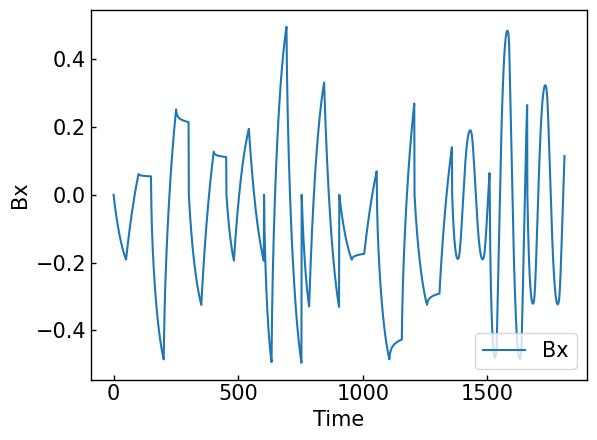

In [57]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "sans-serif"  # 使用するフォント
plt.rcParams["xtick.direction"] = "in"  # x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["ytick.direction"] = "in"  # y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["xtick.major.width"] = 1.0  # x軸主目盛り線の線幅
plt.rcParams["ytick.major.width"] = 1.0  # y軸主目盛り線の線幅
plt.rcParams["font.size"] = 15  # フォントの大きさ
plt.rcParams["axes.linewidth"] = 1.0  # 軸の線幅edge linewidth。囲みの太さ
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(df_concat_bLine_all.iloc[:-1, -1:].values, label="Bx")  # 最後の列のみ、つまり、xb=0.01249のみをプロット
ax.set_xlabel("Time")
ax.set_ylabel("Bx")
# plt.gca().spines[['top', 'right']].set_visible(False)
plt.legend(loc="lower right")
# out_dirに保存
plt.savefig(out_dir + "beforeBx.pdf")

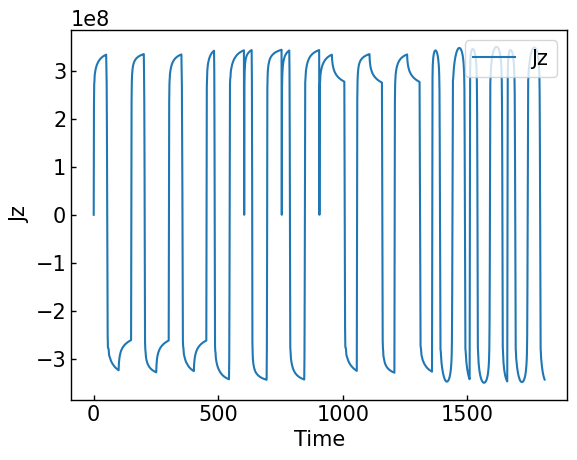

In [56]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "sans-serif"  # 使用するフォント
plt.rcParams["xtick.direction"] = "in"  # x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["ytick.direction"] = "in"  # y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["xtick.major.width"] = 1.0  # x軸主目盛り線の線幅
plt.rcParams["ytick.major.width"] = 1.0  # y軸主目盛り線の線幅
plt.rcParams["font.size"] = 15  # フォントの大きさ
plt.rcParams["axes.linewidth"] = 1.0  # 軸の線幅edge linewidth。囲みの太さ
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(df_concat_jLine_all.iloc[:-1, -1:].values, label="Jz")
ax.set_xlabel("Time")
ax.set_ylabel("Jz")
# plt.gca().spines[['top', 'right']].set_visible(False)
plt.legend(loc="upper right")
plt.savefig(out_dir + "beforeJz.pdf")

In [8]:
# import matplotlib.pyplot as plt
# plt.plot(df_bLine1_3.iloc[:-1,-1:].values)
# # plt.gca().spines[['top', 'right']].set_visible(False)

In [9]:
# df_exp = sns.load_dataset('flights')
# # @title passengers

# from matplotlib import pyplot as plt
# df_exp['passengers'].plot(kind='line', figsize=(8, 4), title='passengers')
# plt.gca().spines[['top', 'right']].set_visible(False)

## データのロードと実験用の整形

In [58]:
ss = StandardScaler()

In [62]:
class AirPassengersDataset(Dataset):
    def __init__(self, flag, seq_len, pred_len):
        # 学習期間と予測期間の設定
        self.seq_len = seq_len
        self.pred_len = pred_len

        # 訓練用、評価用、テスト用を分けるためのフラグ
        type_map = {"train": 0, "val": 1, "test": 2}
        self.set_type = type_map[flag]

        self.__read_data__()

    def __read_data__(self):
        # seabornのデータセットから飛行機の搭乗者数のデータをロード
        df_rawX = df_concat_bLine_all
        df_rawY = df_concat_jLine_all

        # 訓練用、評価用、テスト用で呼び出すデータを変える
        # border1s = [0, 1209, 1511] #8:10:12
        # border2s = [302, 1510, 1812]
        border1s = [0, 2416, 2718]  # 16:18:20
        border2s = [2415, 2717, 3019]
        # border1s = [0, 0, 0]  # 8:10:12
        # border2s = [152, 152, 152]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        dataX = df_rawX.iloc[:-1, -1:].values  #
        dataY = df_rawY.iloc[:-1, -1:].values  #

        # data = df_raw.iloc[:-1,-1:].values
        # ss = StandardScaler()
        dataX = ss.fit_transform(dataX)
        dataY = ss.fit_transform(dataY)

        self.dataX = dataX[border1:border2]
        self.dataY = dataY[border1:border2]

    def __getitem__(self, index):
        # 学習用の系列と予測用の系列を出力
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end
        r_end = r_begin + self.pred_len

        src = self.dataX[s_begin:s_end]
        tgt = self.dataY[s_begin:s_end]
        # tgt = self.dataY[r_begin:r_end]

        return src, tgt

    def __len__(self):
        # return len(self.dataX)
        return len(self.dataX) - self.seq_len - self.pred_len + 1

## DataLoaderの定義

In [63]:
def data_provider(flag, seq_len, pred_len, batch_size):
    # flagに合ったデータを出力
    data_set = AirPassengersDataset(flag=flag, seq_len=seq_len, pred_len=pred_len)
    # データをバッチごとに分けて出力できるDataLoaderを使用
    data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=False)
    return data_loader

## エンべディングの定義

In [13]:
# 位置エンコーディングの定義
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout: float = 0.1, max_len: int = 5000) -> None:
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)]
        return self.dropout(x)


# モデルに入力するために次元を拡張する
class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        self.tokenConv = nn.Linear(c_in, d_model)

    def forward(self, x):
        x = self.tokenConv(x)
        return x

## Transformerの定義

In [14]:
class Transformer(nn.Module):
    def __init__(self, num_encoder_layers, num_decoder_layers, d_model, d_input, d_output, dim_feedforward=512, dropout=0.1, nhead=8):
        super(Transformer, self).__init__()

        # エンべディングの定義
        self.token_embedding_src = TokenEmbedding(d_input, d_model)
        self.token_embedding_tgt = TokenEmbedding(d_output, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout)

        # エンコーダの定義
        encoder_layer = TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True, activation="gelu")
        encoder_norm = LayerNorm(d_model)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers, norm=encoder_norm)

        # デコーダの定義
        decoder_layer = TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True, activation="gelu")
        decoder_norm = LayerNorm(d_model)
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers, norm=decoder_norm)

        # 出力層の定義
        self.output = nn.Linear(d_model, d_output)

    def forward(self, src, tgt, mask_src, mask_tgt):
        # mask_src, mask_tgtはセルフアテンションの際に未来のデータにアテンションを向けないためのマスク

        embedding_src = self.positional_encoding(self.token_embedding_src(src))
        memory = self.transformer_encoder(embedding_src, mask_src)

        embedding_tgt = self.positional_encoding(self.token_embedding_tgt(tgt))
        outs = self.transformer_decoder(embedding_tgt, memory, mask_tgt)

        output = self.output(outs)
        return output

    def encode(self, src, mask_src):
        return self.transformer_encoder(self.positional_encoding(self.token_embedding_src(src)), mask_src)

    def decode(self, tgt, memory, mask_tgt):
        return self.transformer_decoder(self.positional_encoding(self.token_embedding_tgt(tgt)), memory, mask_tgt)

## マスクの定義

In [15]:
def create_mask(src, tgt):
    seq_len_src = src.shape[1]
    seq_len_tgt = tgt.shape[1]

    mask_tgt = generate_square_subsequent_mask(seq_len_tgt).to(device)
    mask_src = generate_square_subsequent_mask(seq_len_src).to(device)

    return mask_src, mask_tgt


def generate_square_subsequent_mask(seq_len):
    mask = torch.triu(torch.full((seq_len, seq_len), float("-inf")), diagonal=1)
    return mask

## 訓練、評価の処理を定義

In [16]:
def train(model, data_provider, optimizer, criterion):
    model.train()
    total_loss = []
    count = 0
    for src, tgt in data_provider:
        src = src.float().to(device)
        tgt = tgt.float().to(device)

        input_tgt = tgt[:, :, :]
        # input_tgt = torch.cat((src[:,-1:,:],tgt[:,:-1,:]), dim=1)

        # print('src:',src.size())
        # print('ターゲット:',input_tgt.size())

        mask_src, mask_tgt = create_mask(src, input_tgt)

        print("ソース", mask_src)
        print("た～げ", mask_tgt)

        output = model(src=src, tgt=input_tgt, mask_src=mask_src, mask_tgt=mask_tgt)
        # print('アウトプット:',output.size())
        # print('mask_src:',mask_src)
        # print('mask_tgt:',mask_tgt)

        optimizer.zero_grad()

        loss = criterion(output, tgt)
        loss.backward()
        total_loss.append(loss.cpu().detach())
        optimizer.step()
        count += 1
        # if count == 1209 - src_len:
        #     break

    return np.average(total_loss)


def evaluate(flag, model, data_provider, criterion, epoch):
    model.eval()
    total_loss = []
    for src, tgt in data_provider:
        src = src.float().to(device)
        tgt = tgt.float().to(device)

        seq_len_src = src.shape[1]
        mask_src = (torch.zeros(seq_len_src, seq_len_src)).type(torch.bool)
        mask_src = mask_src.float().to(device)

        memory = model.encode(src, mask_src)
        outputs = tgt[:, -1:, :]
        seq_len_tgt = tgt.shape[1]

        for i in range(seq_len_tgt - 1):
            mask_tgt = (generate_square_subsequent_mask(outputs.size(1))).to(device)

            output = model.decode(outputs, memory, mask_tgt)
            output = model.output(output)

            outputs = torch.cat([outputs, output[:, -1:, :]], dim=1)
            # outputs = torch.cat([outputs, output[:, -1:, :]], dim=1)

        # print('ターゲット',tgt.size())
        # print('アウトｓ:',outputs.size())

        loss = criterion(outputs, tgt)
        total_loss.append(loss.cpu().detach())

    if flag == "test":
        true = tgt
        pred = output
        true = true.squeeze(0).cpu().detach().numpy()
        pred = pred.squeeze(0).cpu().detach().numpy()

        # true = ss.inverse_transform(true)
        # pred = ss.inverse_transform(pred)
        # true = torch.cat((src, tgt), dim=1)
        # pred = torch.cat((src, output), dim=1)

        fig = plt.figure()
        ax = fig.add_subplot()
        ax.plot(true.squeeze(), label="true")
        ax.plot(pred.squeeze(), label="pred")
        ax.set_xlabel("Time")
        ax.set_ylabel("Jz")

        # plt.plot(true.squeeze(), label='true')
        # plt.plot(pred.squeeze(), label='pred')

        # plt.plot(true.squeeze().cpu().detach().numpy(), label='true')
        # plt.plot(pred.squeeze().cpu().detach().numpy(), label='pred')
        plt.legend()
        # plt.savefig('test2.pdf')
        # グラフを保存
        plt.title(f"epoch {epoch}")
        plt.savefig(f"epoch_{epoch}.png")
        plt.clf()

    return np.average(total_loss)

## パラメータなどの定義

In [17]:
d_input = 1
d_output = 1
d_model = 512
nhead = 8
dim_feedforward = 2048
num_encoder_layers = 4
num_decoder_layers = 4
dropout = 0.01
src_len = 151  # 36
tgt_len = 1  # 12
batch_size = 1
epochs = 1
best_loss = float("Inf")
best_model = None

model = Transformer(num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, d_model=d_model, d_input=d_input, d_output=d_output, dim_feedforward=dim_feedforward, dropout=dropout, nhead=nhead)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

criterion = torch.nn.MSELoss()

optimizer = torch.optim.RAdam(model.parameters(), lr=0.0001)

## 訓練と評価用データにおける評価

ソース tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]])
た～げ tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]])
[1/1] train loss: 1.303458, valid loss: 3.527504


<Figure size 640x480 with 0 Axes>

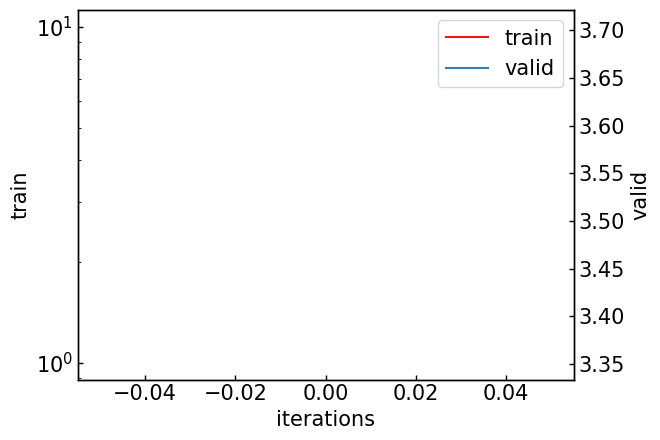

In [18]:
valid_losses = []
train_losses = []
for epoch in range(1, epochs + 1):
    loss_train = train(model=model, data_provider=data_provider("train", src_len, tgt_len, batch_size), optimizer=optimizer, criterion=criterion)

    loss_valid = evaluate(flag="val", model=model, data_provider=data_provider("val", src_len, tgt_len, batch_size), criterion=criterion, epoch=epoch)

    if epoch % 1 == 0:
        print(
            "[{}/{}] train loss: {:.6f}, valid loss: {:.6f}".format(
                epoch,
                epochs,
                loss_train,
                loss_valid,
            )
        )

    valid_losses.append(loss_valid)
    train_losses.append(loss_train)

    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        best_epoch = epoch

    evaluate(flag="test", model=best_model, data_provider=data_provider("test", src_len, tgt_len, batch_size), criterion=criterion, epoch=epoch)

# lossCSV
df_train_loss = pd.Series(train_losses)
df_valid_loss = pd.Series(valid_losses)
df_loss = pd.concat([df_train_loss, df_valid_loss], axis=1)
df_loss.to_csv("loss.csv", index=False)

from matplotlib import cm

# plt.title("Training and Validation Loss")
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(train_losses, color=cm.Set1.colors[0], label="train")
ax2.plot(valid_losses, color=cm.Set1.colors[1], label="valid")
# ax2 = ax2.gca()
ax1.set_yscale("log")
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1 + handler2, label1 + label2, loc="upper right")
ax1.set_xlabel("iterations")
ax1.set_ylabel("train")
ax2.set_ylabel("valid")
# ax2 = ax2.gca()
# ax2.set_yscale('log')
# plt.legend()
plt.savefig("loss.pdf")

## テスト用データにおける予測

In [19]:
# evaluate(flag='test', model=best_model, data_provider=data_provider('test', src_len, tgt_len, batch_size), criterion=criterion,epoch = best_epoch)

In [20]:
# !pip install imageio

In [21]:
# import imageio

# # 画像ファイルをgifに変換
# images = []
# for i in range(1, 1000):
#     images.append(imageio.imread(f"epoch_{i}.png"))
# imageio.mimsave("animation.gif", images, fps=60)


# # # 作成したファイルを削除
# # for i in range(epochs):
# #     import os
# #     os.remove(f'epoch_{i}.png')

# # 作成したgif動画再生
# import IPython

# IPython.display.Image("animation.gif", format="png")